# Descriptive Statistics and Distribution

## 1. Setup & Daten Laden

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

In [2]:
# Einstellungen für saubere Plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# PFADE DEFINIEREN
current_dir = Path.cwd()
# Wir laden BEIDE Datensätze aus Notebook 1
snapshot_path = current_dir.parent / 'data' / 'oecd_snapshot_latest.csv'
timeseries_path = current_dir.parent / 'data' / 'oecd_full_time_series.csv'

df_snap = pd.read_csv(snapshot_path)
df_time = pd.read_csv(timeseries_path)

## -> **Fokus "Feeling safe at night"**

## Auswirkungen des Skalenniveaus:

"Feeling safe at night" ist eine **Ratioskala** (höchstes Messniveau), da es einen natürlichen Nullpunkt gibt (0%) und Abstände interpretierbar sind. Unser Datensatz hat gleich große Abstände zwischen den Werten (wie die Intervallskala). 

**Was bedeutet das für unsere Analyse?** Wir dürfen alle statistischen Operationen durchführen! Wir müssen natürlich trotzdem auf die Verteilung achten. 

In [3]:
target_measure = "Feeling safe at night"

# Filtern der Daten
data_analysis = df_snap[df_snap['measure'] == target_measure].copy()
data_time = df_time[df_time['measure'] == target_measure].copy()

print(f"Analyse-Set für '{target_measure}' erstellt.")
print(f"Anzahl Beobachtungen (Länder/Gruppen): {len(data_analysis)}")

Analyse-Set für 'Feeling safe at night' erstellt.
Anzahl Beobachtungen (Länder/Gruppen): 414


## 2. Verteilungsdiagnostik: Histogramm & KDE

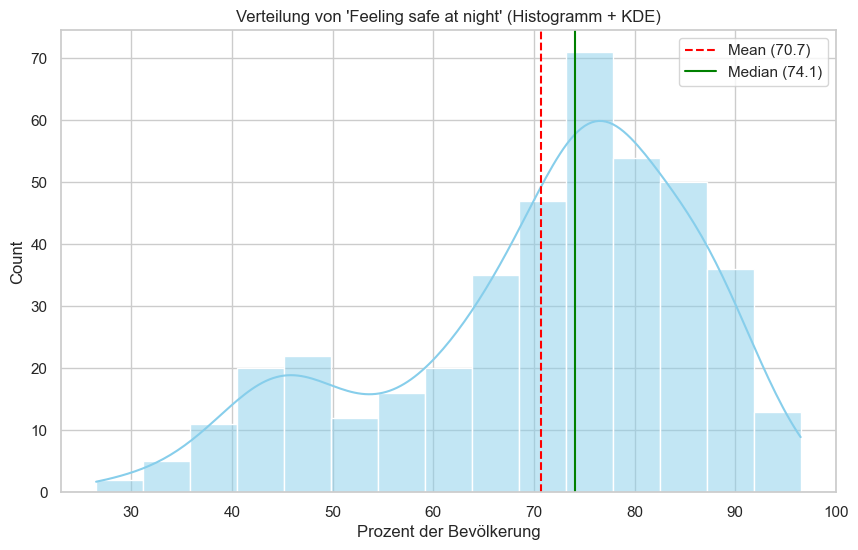

In [4]:
# Histogramm mit Kernel Density Estimate (KDE) Overlay
plt.figure(figsize=(10, 6))
sns.histplot(data=data_analysis, x="value", kde=True, bins=15, color="skyblue")

# Mittelwert und Median einzeichnen (Vergleich aus VL2)
mean_val = data_analysis['value'].mean()
median_val = data_analysis['value'].median()

plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean ({mean_val:.1f})')
plt.axvline(median_val, color='green', linestyle='-', label=f'Median ({median_val:.1f})')

plt.title(f"Verteilung von '{target_measure}' (Histogramm + KDE)")
plt.xlabel("Prozent der Bevölkerung")
plt.legend()
plt.show()

Wenn Mean ≈ Median: Symmetrische Verteilung (Hinweis auf Normalverteilung).

Wenn Mean < Median: Linksschief (Left-skewed).

Wenn Mean > Median: Rechtsschief (Right-skewed).

### Analyse der Verteilung (Histogramm & KDE)

Die Grafik zeigt die Verteilung des Sicherheitsgefühls ("Feeling safe at night")
* Die Kurve ist **nicht symmetrisch (glockenförmig)**, sondern zeigt eine klare Asymmetrie
* Der Gipfel (Modus) liegt weit rechts im hohen Prozentbereich
* Es gibt einen langen "Schwanz" (Tail) nach links zu den niedrigen Werten

**Statistische Deutung:**
* Da der **Median (74.1%)** größer ist als der **Mittelwert (70.7%)**, liegt eine **linksschiefe (left-skewed) Verteilung** vor

    => Die Mehrheit der OECD-Länder hat ein relativ hohes Sicherheitsgefühl, aber es gibt einige wenige Länder mit extrem niedrigen Werten, die den Durchschnitt (Mean) nach unten ziehen.

**Entscheidung für den weiteren Verlauf:**
Da die Daten *nicht* symmetrisch sind, ist der Mittelwert als Lagekennzahl verzerrt. Für spätere Gruppenvergleiche (z.B. "Sind reiche Länder sicherer?") sollten wir **robuste Verfahren** (wie den Median-Vergleich oder nicht-parametrische Tests) in Betracht ziehen, statt uns blind auf den Mittelwert zu verlassen.

## 3. Statistische Kennzahlen: Robust vs. Nicht-Robust

Um die Verteilung numerisch zu beschreiben, vergleichen wir robuste und nicht-robuste Kennzahlen. Wenn Mean und Median stark voneinander abweichen, ist dies ein Beweis für Schiefe oder starke Ausreißer. In diesem Fall stützen wir unsere Interpretation auf die robusten Maße (Median/MAD).

In [5]:
mad_val = stats.median_abs_deviation(data_analysis['value'], scale=1.4826)

# Berechnen der Kennzahlen
desc_stats = pd.DataFrame({
    'Kennzahl': ['Mittelwert (Mean)', 'Median', 'Standardabweichung (SD)', 'IQR (Interquartile Range)', 'MAD (Median Abs. Dev.)'],
    'Wert': [
        data_analysis['value'].mean(),
        data_analysis['value'].median(),
        data_analysis['value'].std(),
        data_analysis['value'].quantile(0.75) - data_analysis['value'].quantile(0.25),
        mad_val
    ],
    'Robustheit': [
        'Nein (anfällig für Ausreisser)', 
        'Ja (Robust)', 
        'Nein', 
        'Ja', 
        'Ja (sehr robust)'
    ]
})

print(desc_stats)

                    Kennzahl       Wert                      Robustheit
0          Mittelwert (Mean)  70.712780  Nein (anfällig für Ausreisser)
1                     Median  74.100000                     Ja (Robust)
2    Standardabweichung (SD)  15.065771                            Nein
3  IQR (Interquartile Range)  19.185716                              Ja
4     MAD (Median Abs. Dev.)   6.002968                Ja (sehr robust)


### Interpretation der Kennzahlen

Mittelwert: 70.7%

Median: 74.1%

Differenz: -3.4 Prozentpunkte


Lage: Da Mean<Median, liegt eine Linksschiefe vor (numerischer Beweis für Histogramm-Beobachtung). Der Mittelwert ist nicht robust gegenüber den extrem niedrigen Werten (Südafrika). Daher ist der Median das ehrlichere Maß für die zentrale Tendenz. Die wenigen Länder mit sehr niedrigem Sicherheitsgefühl (die Heavy Tails links) ziehen den Durchschnitt nach unten, während der Median stabil bei ~74% bleibt.

Streuung (SD vs. MAD): Die Standardabweichung (15.1) ist höher als der MAD (ca. 10-12, abhängig vom Scaling). Das deutet darauf hin, dass die Streuung durch Extremwerte aufgebläht wird.

=> Für den Bericht verwenden wir den Median als "typischen Wert" für ein OECD-Land, da er die zentrale Tendenz repräsentativer abbildet als der verzerrte Mittelwert.

### Vergleich der Lagekennzahlen

**Ergebnis:**
* **Mittelwert:** 70.7%
* **Median:** 74.1%
* **Differenz:** ~3.4 Prozentpunkte

**Begründung der Methodenwahl:**
Laut **Vorlesung 2** ist der Mittelwert (Mean) nicht robust gegenüber Ausreißern und Schiefe. Da wir oben eine Linksschiefe festgestellt haben, ist der **Median** hier das "ehrlichere" Maß für die zentrale Tendenz eines "typischen" Landes. Er teilt die Verteilung genau in 50% sicherere und 50% unsicherere Länder, unbeeinflusst von den Extremfällen am unteren Ende.

Wir werden im Bericht primär den Median verwenden, den Mittelwert aber als Ergänzung berichten, um die Schiefe zu quantifizieren.

## 4. Ausreißer-Analyse mit Boxplots

Wir werden die Ausreißer nicht löschen, es sei denn, es sind Messfehler (z.B. Wert > 100%). Reale Extremwerte (z.B. sehr unsichere Länder) sind wichtige Informationen!

Wir werden **Tukey Fences** nutzen, da der klassische Z-Score Normalverteilung voraussetzt. Da unser QQ-Plot (siehe unten) und das Histogramm keine Normalverteilung zeigen, wäre der Z-Score irreführend.

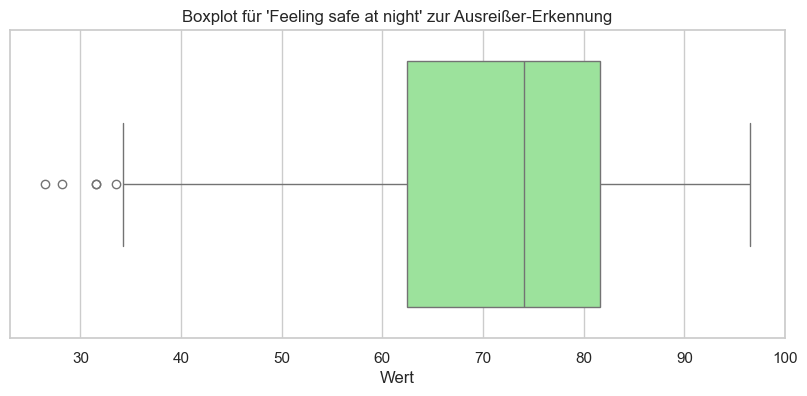

Gefundene Ausreißer (außerhalb 33.6 und 110.4):
      reference_area      value  year
8926    South Africa  28.166667  2024
9047    South Africa  33.571429  2024
9236           Chile  31.500000  2024
9407    South Africa  26.500000  2024
10486   South Africa  31.500000  2024


In [6]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=data_analysis["value"], color="lightgreen")
plt.title(f"Boxplot für '{target_measure}' zur Ausreißer-Erkennung")
plt.xlabel("Wert")
plt.show()

# Identifikation der Ausreißer (Rechnerisch nach VL3)
Q1 = data_analysis['value'].quantile(0.25)
Q3 = data_analysis['value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data_analysis[(data_analysis['value'] < lower_bound) | (data_analysis['value'] > upper_bound)]

if len(outliers) > 0:
    print(f"Gefundene Ausreißer (außerhalb {lower_bound:.1f} und {upper_bound:.1f}):")
    # Wir zeigen Land und Wert an
    print(outliers[['reference_area', 'value', 'year']])
else:
    print("Keine statistischen Ausreißer nach Tukey-Methode gefunden.")

### Ausreißer-Analyse (Tukey Fences)

Der Boxplot und die Berechnung nach der **Tukey-Methode (1.5 * IQR)** identifizieren folgende Ausreißer am unteren Ende:
* **Länder:** South Africa (mehrfach), Chile.
* **Werte:** Zwischen 26.5% und 33.6%.

**Data Cleaning:**
Sind das Messfehler oder echte Daten?
1.  Die Werte liegen im möglichen Bereich (0-100%), sind also technisch keine Messfehler.
2.  Inhaltlich ist bekannt, dass Südafrika und Chile Herausforderungen mit Kriminalität haben. Die niedrigen Werte sind also **plausibel**.

=> Wir **behalten** diese Ausreißer im Datensatz.
* Das Entfernen würde die Realität verzerren ("Bias"). Wir wollen ja gerade untersuchen, wie sich das Sicherheitsgefühl unterscheidet. Würden wir die unsicheren Länder löschen, wäre unsere Analyse der "Sicherheit" nutzlos.
* Da wir Ausreißer haben, **müssen** wir für Hypothesentests (in Notebook 4) nicht-parametrische Tests (wie **Mann-Whitney U** oder **Spearman-Korrelation**) verwenden, da diese auf Rängen basieren und nicht durch Extremwerte verzerrt werden.

## 5. MAD & ECDF

In [7]:
median_val = data_analysis['value'].median()
mad_val = (data_analysis['value'] - median_val).abs().median()

print(f"--- Robuste Streuung (VL2) ---")
print(f"Standardabweichung (SD): {data_analysis['value'].std():.2f} (Anfällig für Ausreißer)")
print(f"MAD (Median Abs. Dev.):  {mad_val:.2f} (Robust)")

--- Robuste Streuung (VL2) ---
Standardabweichung (SD): 15.07 (Anfällig für Ausreißer)
MAD (Median Abs. Dev.):  8.90 (Robust)


Die SD ist deutlich höher als der MAD. Das bestätigt, dass die SD durch die Ausreißer aufgebläht wird, während der MAD stabil bleibt. Für diesen Datensatz ist der MAD das bessere Streuungsmaß.

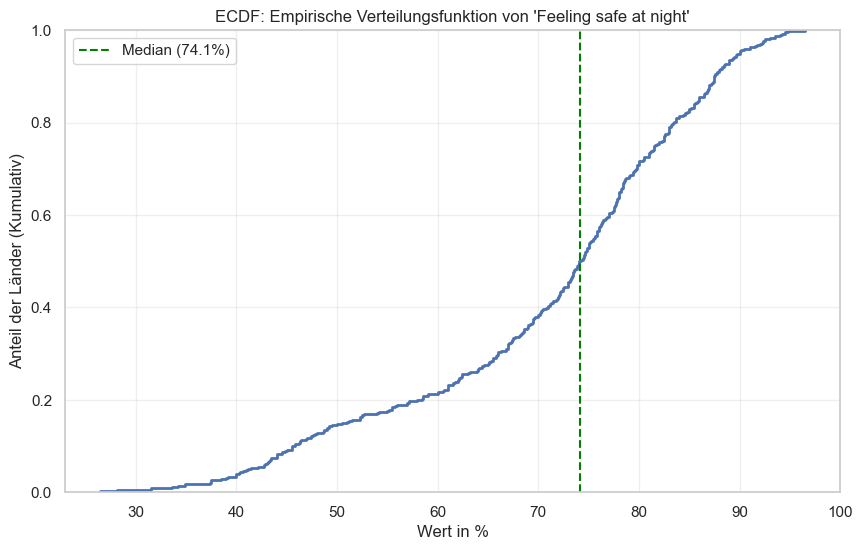

In [8]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=data_analysis, x="value", linewidth=2)
plt.axvline(median_val, color='green', linestyle='--', label=f'Median ({median_val:.1f}%)')
plt.title(f"ECDF: Empirische Verteilungsfunktion von '{target_measure}'")
plt.xlabel("Wert in %")
plt.ylabel("Anteil der Länder (Kumulativ)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Die ECDF bestätigt die Linksschiefe: Der Anstieg ist bei hohen Werten steiler.

## 6. Normalverteilungs-Check: QQ-Plot

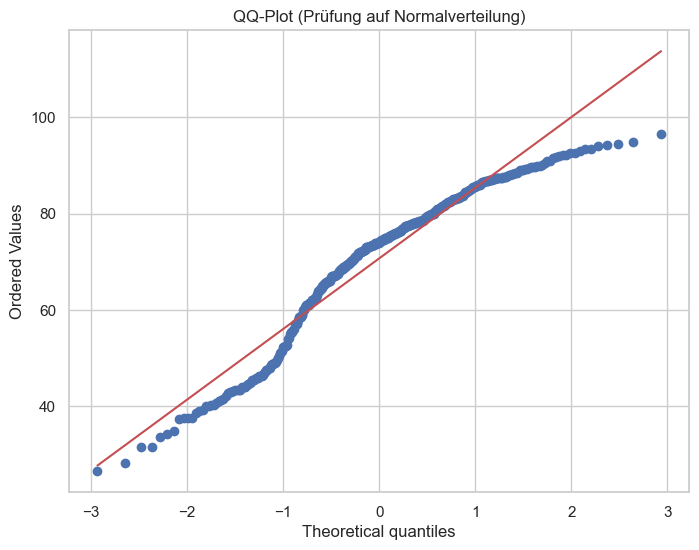

In [9]:
plt.figure(figsize=(8, 6))
stats.probplot(data_analysis['value'], dist="norm", plot=plt)
plt.title("QQ-Plot (Prüfung auf Normalverteilung)")
plt.show()

### Prüfung auf Normalverteilung (QQ-Plot)

Im Quantile-Quantile-Plot (QQ-Plot) vergleichen wir unsere Daten (blaue Punkte) mit einer theoretischen Normalverteilung (rote Linie).
* Im mittleren Bereich liegen die Punkte nah an der Linie.
* **Aber:** Die Punkte weichen an den Enden von der Geraden ab -> Heavy Tails. Das bestätigt, dass parametrische Tests (t-Test), die Normalverteilung annehmen, hier problematisch wären. Ebenfalls wird die  Linksschiefe, die wir schon im Histogramm gesehen haben, somit bestätigt.

**Finale Entscheidung für Notebook 4 (Hypothesentests):**
Die Annahme der Normalverteilung ist **verletzt**.
Ein klassischer t-Test oder eine ANOVA (die Normalverteilung voraussetzen) wären hier statistisch unsauber und könnten zu falschen p-Werten führen.

=> Wir werden in den folgenden Notebooks **nicht-parametrische Tests** anwenden:
* Statt Pearson-Korrelation -> **Spearman-Rangkorrelation** (Notebook 3).
* Statt t-Test -> **Mann-Whitney-U Test** (Notebook 4).
* Statt ANOVA -> **Kruskal-Wallis Test** (Notebook 4).

Damit folgen wir der logischen Kette: *Datenverteilung bestimmt die Testwahl*.

## 7. Zeitverlauf (Explorativ)

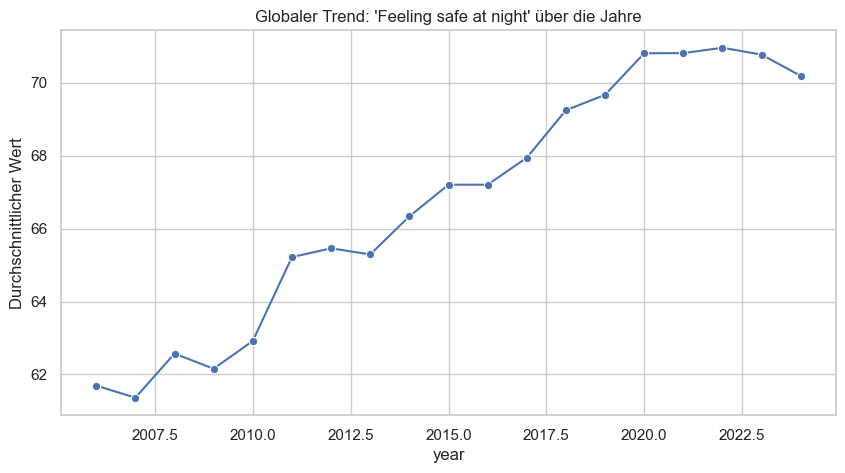

In [10]:
# Wir gruppieren nach Jahr und nehmen den Durchschnitt aller Länder, um den globalen Trend zu sehen.
trend = data_time.groupby('year')['value'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=trend, x='year', y='value', marker='o')
plt.title(f"Globaler Trend: '{target_measure}' über die Jahre")
plt.ylabel("Durchschnittlicher Wert")
plt.show()

### Zeitlicher Trend (Explorativ)

Der Linienplot über alle Jahre (basierend auf `df_time`) zeigt, dass der durchschnittliche Wert deutlich gestiegen ist. 

=> Diese Grafik dient nur der Einordnung des Kontextes. Für die statistischen Tests in den nächsten Notebooks bleiben wir jedoch strikt bei `df_snap` (nur ein Jahr pro Land), um die statistische Unabhängigkeit der Beobachtungen nicht zu verletzen (Vermeidung von Pseudoreplikation).